In [50]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, save_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPooling2D, LeakyReLU, Activation, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import random
from tensorflow.keras import layers

In [51]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
# Dataset Path (Change if dataset is stored in a different location)
dataset_path = "/content/drive/MyDrive/Lab NNDL/Lung Disease Dataset/train"

# Define Image Size and Categories
IMG_SIZE = 128
CATEGORIES = ["Bacterial Pneumonia", "Corona Virus Disease", "Normal", "Tuberculosis","Viral Pneumonia"]  # Adjust categories based on dataset=

In [62]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Assuming you have set up the image data directory
data_dir = '/content/drive/MyDrive/Lab NNDL/Lung Disease Dataset'  # Update to your dataset path

# Create an ImageDataGenerator instance for loading and preprocessing images
datagen = ImageDataGenerator(rescale=1./255)  # Normalize images between 0 and 1

# Load training data from the directory
train_data = datagen.flow_from_directory(
    data_dir + '/train',  # Directory where your images are located
    target_size=(224, 224),  # Resize images to 224x224
    batch_size=32,  # Batch size
    class_mode='categorical',  # Labels are one-hot encoded
    shuffle=True
)

# Create X_train and y_train from the data generator
X_train, y_train = next(train_data)  # Get one batch of data


Found 6054 images belonging to 5 classes.


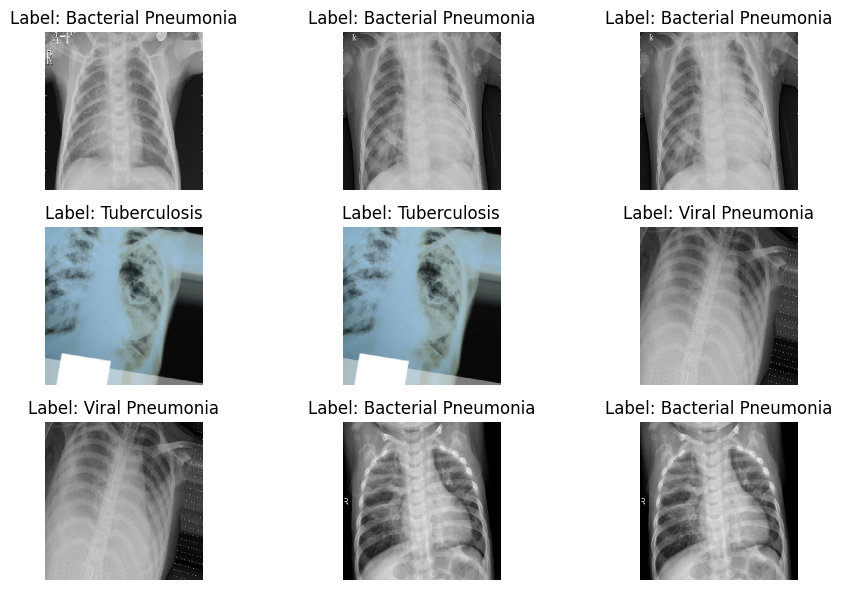

In [63]:
import random

plt.figure(figsize=(10, 6))
for i in range(9):  # Show 9 images
    index = random.randint(0, len(X_train) - 1)
    plt.subplot(3, 3, i+1)
    plt.imshow(X_train[index])  # Display image
    plt.title(f"Label: {CATEGORIES[np.argmax(y_train[index])]}")  # Display category
    plt.axis("off")  # Hide axes
plt.tight_layout()
plt.show()

In [64]:
# Load and preprocess the dataset
def load_data(data_dir):
    data = []
    labels = []

    for category in CATEGORIES:
        path = os.path.join(data_dir, category)
        class_num = CATEGORIES.index(category)

        for img_name in os.listdir(path):
            try:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                data.append(img)
                labels.append(class_num)
            except Exception as e:
                print(f"Error loading image: {img_path}, Error: {e}")

    data = np.array(data) / 255.0  # Normalize
    labels = np.array(labels)
    return data, labels

In [67]:
# Load dataset
X, y = load_data(dataset_path)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# One-hot encoding of labels
encoder = LabelBinarizer()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [68]:
# Model creation function
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        BatchNormalization(),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(CATEGORIES), activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create model and display summary
model = create_model()
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 63, 63, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 30, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,181 (12.61 MB)

 Trainable params: 3,305,733 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [69]:
import seaborn as sns
# Callbacks
callbacks = [
    ModelCheckpoint('.mdl_wts.keras', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=1e-10),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32, callbacks=callbacks)

Epoch 1/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.5550 - loss: 2.4112
Epoch 1: val_loss improved from inf to 4.89797, saving model to .mdl_wts.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 114s 730ms/step - accuracy: 0.5553 - loss: 2.4073 - val_accuracy: 0.2890 - val_loss: 4.8980 - learning_rate: 0.0010
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 662ms/step - accuracy: 0.6767 - loss: 1.0729
Epoch 2: val_loss improved from 4.89797 to 3.52641, saving model to .mdl_wts.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 111s 731ms/step - accuracy: 0.6768 - loss: 1.0730 - val_accuracy: 0.4608 - val_loss: 3.5264 - learning_rate: 0.0010
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.6808 - loss: 0.8541
Epoch 3: val_loss improved from 3.52641 to 0.98012, saving model to .mdl_wts.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 152s 799ms/step - accuracy: 0.6809 - loss: 0.8541 - val_accuracy: 0.6144 - val_loss: 0.9801 - learning_rate: 0.0010
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - 

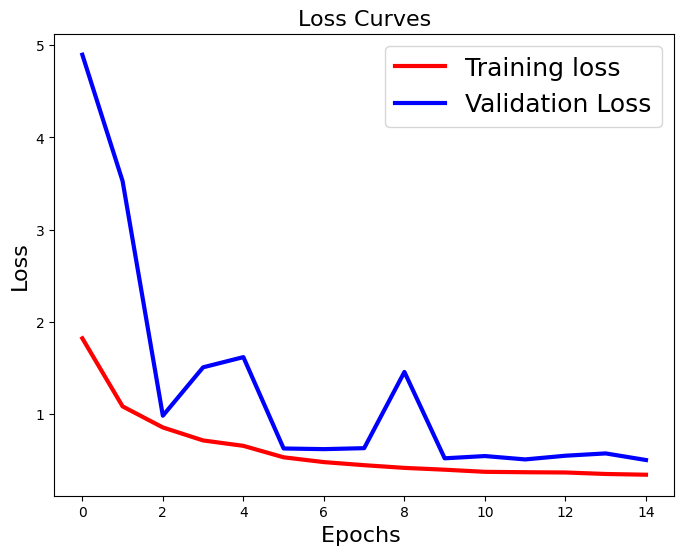

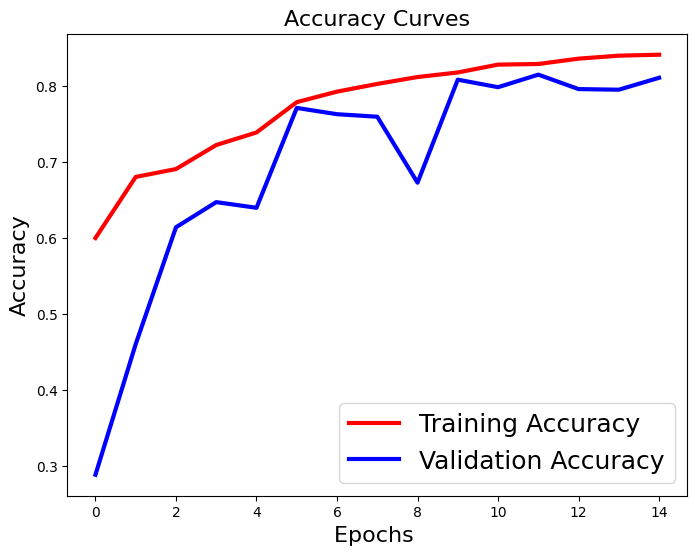

In [70]:
# Plot Loss and Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'], 'r', linewidth=3.0)
plt.plot(history.history['val_loss'], 'b', linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss Curves', fontsize=16)
plt.show()

plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
plt.xlabel('Epochs ', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves', fontsize=16)
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


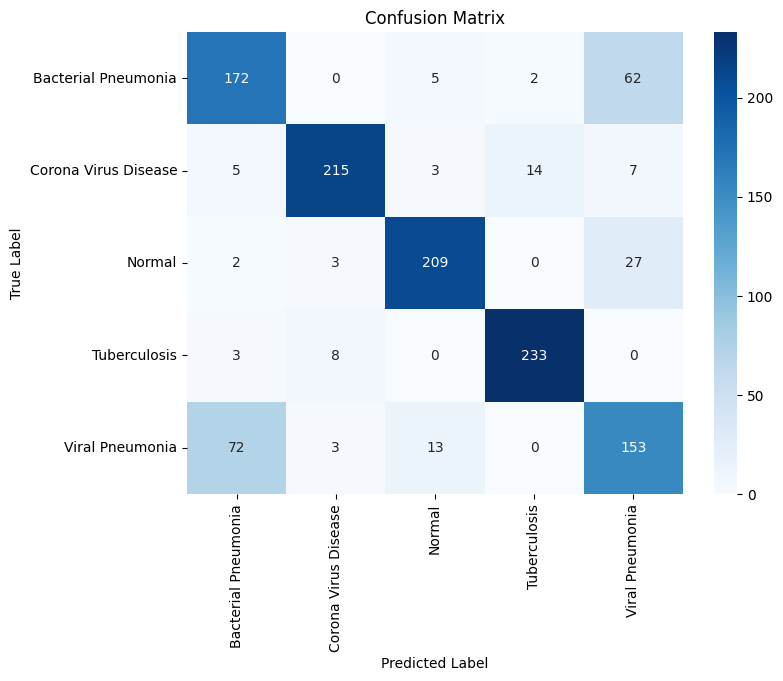

In [71]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [72]:
# Classification Report
predicted_classes = np.argmax(model.predict(X_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), predicted_classes, target_names=CATEGORIES))

38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 202ms/step
                      precision    recall  f1-score   support

 Bacterial Pneumonia       0.68      0.71      0.69       241
Corona Virus Disease       0.94      0.88      0.91       244
              Normal       0.91      0.87      0.89       241
        Tuberculosis       0.94      0.95      0.95       244
     Viral Pneumonia       0.61      0.63      0.62       241

            accuracy                           0.81      1211
           macro avg       0.81      0.81      0.81      1211
        weighted avg       0.82      0.81      0.81      1211



76/76 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step


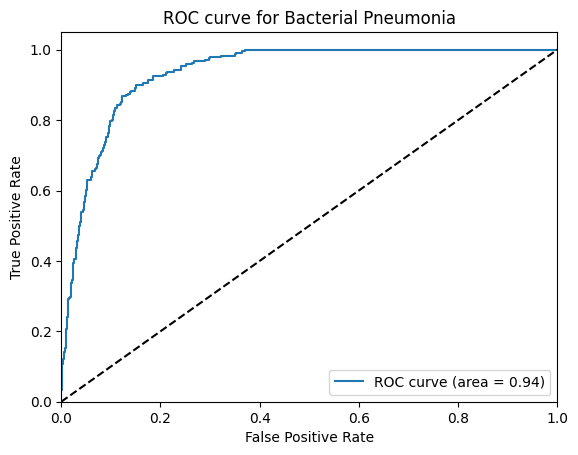

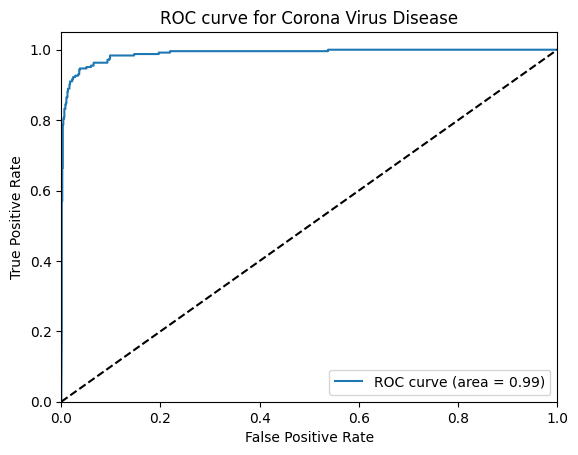

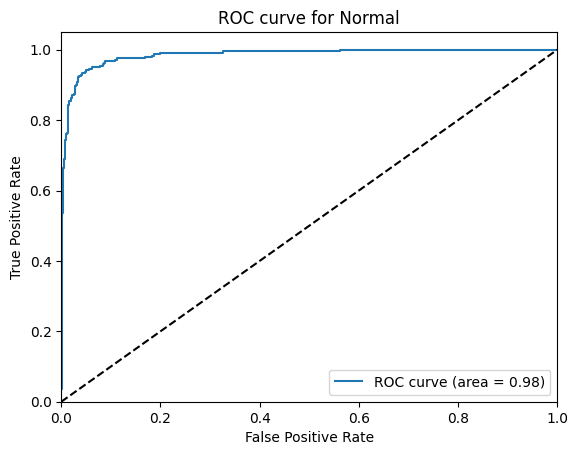

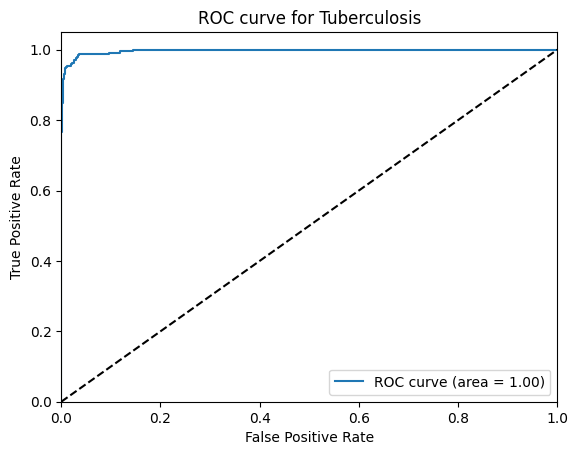

In [73]:
from sklearn.metrics import roc_curve, auc

# ROC Curve
y_test = np.array(y_test)
n_classes = 4

pred_Y = model.predict(X_test, batch_size=16, verbose=True)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred_Y[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred_Y.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve for {CATEGORIES[i]}')
    plt.legend(loc="lower right")
    plt.show()

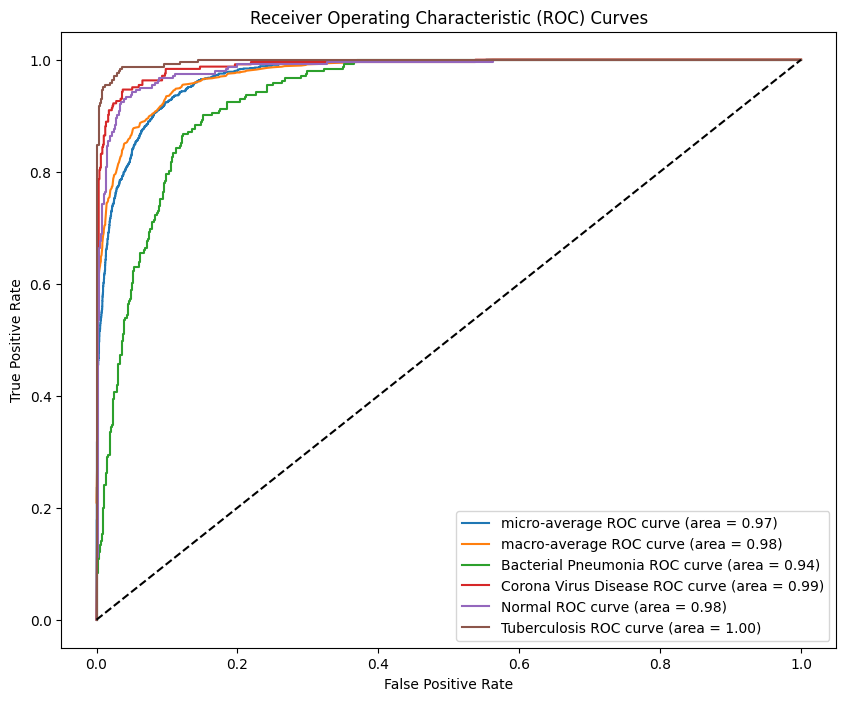

In [74]:
# Plot all ROC Curves
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

fig = plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"], label='micro-average ROC curve (area = %0.2f)' % roc_auc["micro"])
plt.plot(fpr["macro"], tpr["macro"], label='macro-average ROC curve (area = %0.2f)' % roc_auc["macro"])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{CATEGORIES[i]} ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()